This code plots the bootstrapped partial dependence plots

In [1]:
# import libraries
library(data.table)
library(ggplot2)
library(ggthemes)
library(gridExtra)

Warning message:
"package 'data.table' was built under R version 3.4.4"Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'ggthemes' was built under R version 3.4.4"Warning message:
"package 'gridExtra' was built under R version 3.4.4"

In [2]:
grid.size <- 500

In [3]:
# import the data
file_names <- list.files(path = paste0("../../data/regression/bootstrap_", grid.size),pattern = ".csv")
file_names <- paste0("../../data/regression/bootstrap_", grid.size,'/',file_names)
dt <- do.call(rbind,lapply(file_names,fread))

# import raw data for the histograms
df = fread(paste0('../../data/data_regressions_', grid.size, '_20190324.csv'))

# Plot the PDPs

In [5]:
plots <- list()
ncol.plot <- 5
# xlims <- c(0,30)

In [6]:
# import the feature order
features = c('tree_mean','alb_mean','bldg')

In [7]:
# calculate the histogram for each of the features
# df_hist <- df[density_housesarea > xlims[1] & density_housesarea < xlims[2],]

In [8]:
# determine the axis limits
y_min <- round(min(dt[,'mean'])*2)/2
y_max <- round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min

dt_sub <- dt[dependent == 'lst_night_mean',]

for (i in seq(3)){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(var) + 
        ylab('change in % prevalance') +
#         scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=10),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = 10)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = seq(ylims[1], ylims[2],length = 5), labels= seq(y_min,y_max,length = 5)) + 
#         ggtitle(health_titles[var]) + 
#         theme_black() + 
        theme(text=element_text(size=10),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = 10)
             )
    # plot the histogram
    plt <- plt + geom_histogram(data=df, bins=30, mapping=aes_string(var, '..density..*4'), color = FALSE, fill = 'black', alpha = 0.3, size= 0)
#     plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave(paste0('../fig/pdp_uncert_',var,'.png'), plt, width=3, height=2.5)
    }

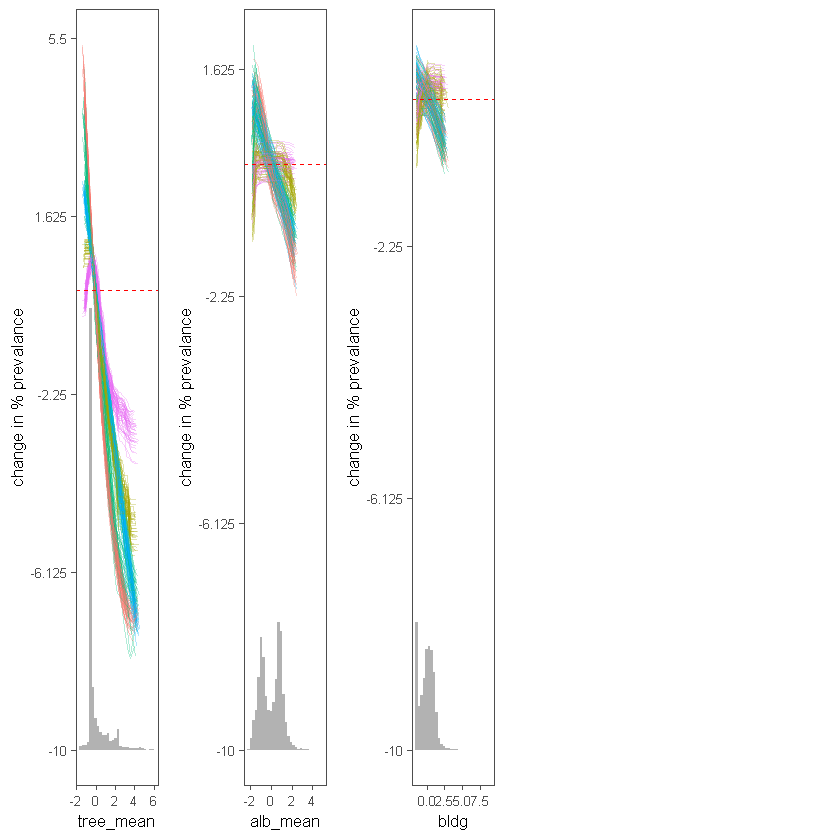

In [9]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))

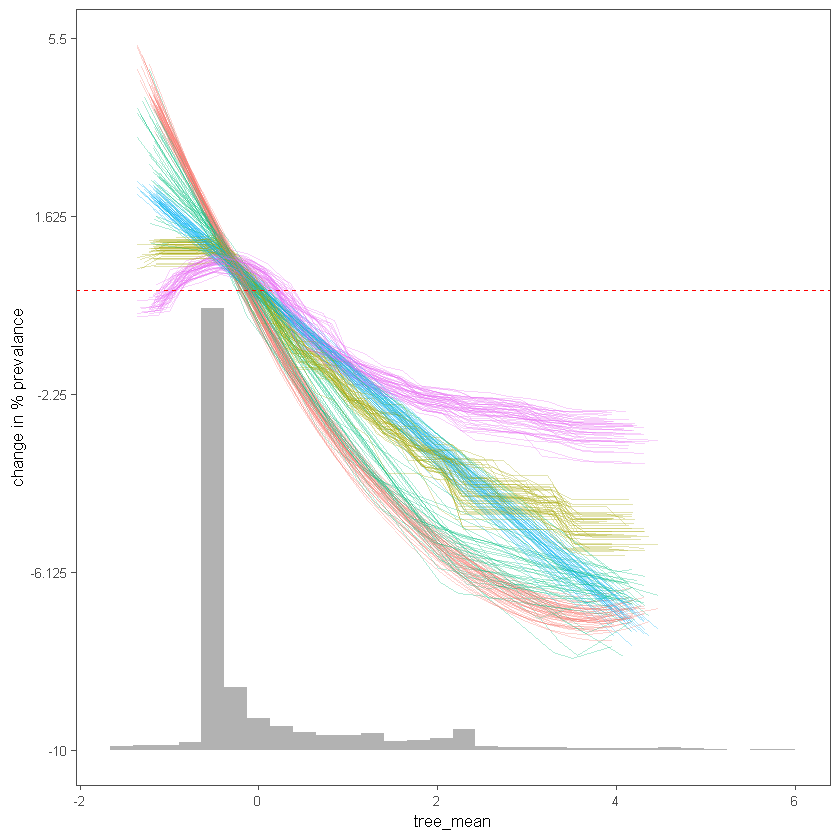

In [10]:
plots[[1]]